# NeuroJack AI

### 1. Introduction

This notebook explores a variety of baseline agents designed to play Blackjack using the OpenAI Gym environment `Blackjack-v1`. The goal is to establish reference performance levels for comparison with more advanced AI learning models.

We implement and evaluate the following agents:

- Random Policy Agent: Selects actions randomly, serving as a naive benchmark.

- Fixed Policy Agent: Follows a simple deterministic strategy (e.g., always "stick" or "hit" under certain conditions).

- Q-Learning Agent: Uses a basic tabular Q-learning algorithm to learn an optimal policy from interaction with the environment.

Each agent is trained and tested over multiple episodes to assess its performance. These baselines provide a foundation for understanding how different levels of strategy affect success in Blackjack, and they serve as points of comparison for more complex RL approaches explored later.

### 2. Environment Setup

We initialize the Blackjack environment and outline the state and action spaces. This section covers necessary imports and environment-specific details essential for understanding how the agents interact with the game.

In [1]:
# Import necessary libraries for environment interaction, numerical operations, plotting, and data structures.
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from neurojack.env import BlackjackEnv # Import the custom environment

# Create the Blackjack environment
env = BlackjackEnv(render_mode=None, num_decks=1, blackjack_payout=1.5,
                         allow_doubling=False, allow_splitting=False, count_cards=False)

### 3. Baseline Policies

#### 3.1 Random Policy

A naive agent that selects actions uniformly at random. This policy serves as a minimal baseline, representing the performance of an unskilled player.

In [2]:
def random_policy(state, info):
    """
    Selects an action at random from the currently available actions.

    Parameters:
        state (tuple): The current state of the environment (not used in this policy).
        info (dict): Dictionary containing information about available actions (e.g., 'can_double', 'can_split').

    Returns:
        int: Randomly chosen action (0: Stand, 1: Hit, 2: Double Down, 3: Split).
    """
    available_actions = [0, 1] # Stand (0) and Hit (1) are always available
    if info.get('can_double', False):
        available_actions.append(2) # Double Down (2) is conditional
    if info.get('can_split', False):
        available_actions.append(3) # Split (3) is conditional
    
    return random.choice(available_actions)


def run_random_agent(episodes=10000):
    """
    Runs the Blackjack environment using a random policy for a given number of episodes.

    Parameters:
        episodes (int): Number of episodes to simulate.

    Returns:
        list: A list containing the final reward for each episode.
              Reward is +1 for a win, 0 for a draw, and -1 for a loss.
    """
    rewards = []  # List to store rewards from each episode

    for _ in range(episodes):
        state, info = env.reset()  # Reset environment and get initial state and info
        done = False

        while not done:
            action = random_policy(state, info)  # Select a random action, pass info
            state, reward, done, info = env.step(action)  # Take a step in the environment, get new info

        rewards.append(reward)  # Store the final reward after episode ends

    return rewards

#### 3.2 One-Move Policy

A simple heuristic-based agent that hits when the player's hand sum is less than 18 and sticks otherwise. This policy introduces a basic strategy for comparison.

In [3]:
def one_move_policy(state, info):
    """
    A simple deterministic policy based on the player's current hand total.
    
    Parameters:
        state (tuple): A tuple representing the current state of the game,
                       formatted as (player_sum, dealer_card, usable_ace).
        info (dict): Dictionary containing information about available actions (not directly used for decision, but passed for consistency).
    
    Returns:
        int: Action to take (0 = hit, 1 = stand).
             Hit if player's sum is less than 18, otherwise stand.
    """
    player_sum, _, _ = state # Custom env state is (player_sum, dealer_card, usable_ace)
    # This policy only ever chooses HIT (0) or STAND (1).
    # These are always valid actions in the BlackjackEnv.
    return 0 if player_sum <= 17 else 1  # 0 = hit, 1 = stand


def run_one_move_agent(episodes=10000):
    """
    Runs the Blackjack environment using the one-move policy over multiple episodes.

    Parameters:
        episodes (int): Number of episodes to simulate.

    Returns:
        list: A list containing the final reward for each episode.
              Reward is +1 for a win, 0 for a draw, and -1 for a loss.
    """
    rewards = []  # List to store rewards from each episode

    for _ in range(episodes):
        state, info = env.reset()  # Reset the environment and get the initial state and info
        done = False

        while not done:
            action = one_move_policy(state, info)  # Use one-move policy to decide the action, pass info
            state, reward, done, info = env.step(action)  # Take action and observe results, get new info

        rewards.append(reward)  # Store reward at the end of the episode

    return rewards

#### 3.3. Evaluating Baseline Policies

We evaluate both the random and one-move policies by running them for multiple episodes and collecting rewards.


In [4]:
# Run and evaluate
random_rewards = run_random_agent()
print(f"Random Policy average reward over 10k episodes: {np.mean(random_rewards):.4f}")

Random Policy average reward over 10k episodes: -0.3529


In [5]:
# Run and evaluate
one_move_rewards = run_one_move_agent()
print(f"One-Move Policy average reward over 10k episodes: {np.mean(one_move_rewards):.4f}")

One-Move Policy average reward over 10k episodes: -0.5139


### 4. Q-Learning Agent

#### 4.1 Training the Q-Learning Agent

We implement a tabular Q-learning agent with parameters for learning rate (alpha), discount factor (gamma), and exploration rate (epsilon). This section describes the training process over many episodes, using an ε-greedy policy for exploration.

In [6]:
def train_q_agent(episodes=500_000, alpha=0.1, gamma=1.0, epsilon=0.1):
    """
    Trains a Q-learning agent to play Blackjack using the tabular method.

    Parameters:
        episodes (int): Number of training episodes.
        alpha (float): Learning rate (how much new information overrides old).
        gamma (float): Discount factor (importance of future rewards).
        epsilon (float): Exploration rate (probability of taking a random action).

    Returns:
        defaultdict: A Q-table mapping state-action pairs to values.
    """
    # Initialize Q-table for all possible actions in our custom environment
    Q = defaultdict(lambda: np.zeros(env.num_actions))

    for _ in range(episodes):
        state, info = env.reset()  # Reset environment and get initial state and info
        done = False

        while not done:
            # ε-greedy action selection: explore or exploit
            if np.random.rand() < epsilon:
                # Select a random action from the *possible* actions for the environment
                action = random.choice(range(env.num_actions))
            else:
                # Select the greedy action from Q-table.
                # If a state is new, Q[state] will be all zeros, so argmax will pick 0 (Stand).
                action = np.argmax(Q[state])

            # Take action and observe the result
            next_state, reward, done, info = env.step(action) # Get new info

            # Get value of the best next action (0 if episode ended)
            best_next = 0 if done else np.max(Q[next_state])

            # Q-learning update rule
            Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])

            # Move to the next state
            state = next_state

    return Q

#### 4.2 Evaluating the Q-Learning Agent

The trained Q-learning policy is evaluated over numerous episodes to assess its performance. Results are compared with the baseline policies to demonstrate learning improvements.

In [7]:
def evaluate_q_policy(Q, episodes=10000):
    """
    Evaluates a learned Q-table policy by running it in the environment.

    Parameters:
        Q (dict): Trained Q-table.
        episodes (int): Number of episodes to evaluate the policy.

    Returns:
        list: A list of rewards from each episode.
              Reward is +1 for a win, 0 for a draw, and -1 for a loss.
    """
    rewards = []  # List to store rewards from each episode

    for _ in range(episodes):
        state, info = env.reset()  # Reset the environment and get info
        done = False

        while not done:
            # Handle potential unseen states during evaluation
            if state not in Q or np.all(Q[state] == 0):
                # If state is new or Q-values are all zero, pick a random action from possible actions
                action = random.choice(range(env.num_actions))
            else:
                action = np.argmax(Q[state])  # Choose the best known action from Q-table

            state, reward, done, info = env.step(action)  # Take the action, get new info

        rewards.append(reward)  # Store the outcome of the episode

    return rewards

In [8]:
# Train Q-learning agent
Q = train_q_agent(episodes=500_000)

# Evaluate
q_learning_rewards = evaluate_q_policy(Q)
print(f"Q-Learning Policy average reward over 10k episodes: {np.mean(q_learning_rewards):.4f}")

Q-Learning Policy average reward over 10k episodes: -0.0494


### 5. Results and Discussion

We summarize and compare the performance of all agents through plots and statistical analysis. This section interprets the results, discusses the effectiveness of different policies, and addresses the limitations of the approaches explored.

In [9]:
def plot_results(results_dict):
    """
    Plots the smoothed average rewards for different Blackjack agents.

    Parameters:
        results_dict (dict): A dictionary where keys are agent names (str)
                             and values are lists of episode rewards (list of int).
    """
    for label, rewards in results_dict.items():
        # Smooth the reward curve using a moving average over 1000 episodes
        avg = np.convolve(rewards, np.ones(1000)/1000, mode='valid')
        plt.plot(avg, label=label)  # Plot the moving average for each agent

    # Set plot title and axis labels
    plt.title("Blackjack Baseline Agents")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")

    # Add legend and grid for better readability
    plt.legend()
    plt.grid(True)
    plt.show()


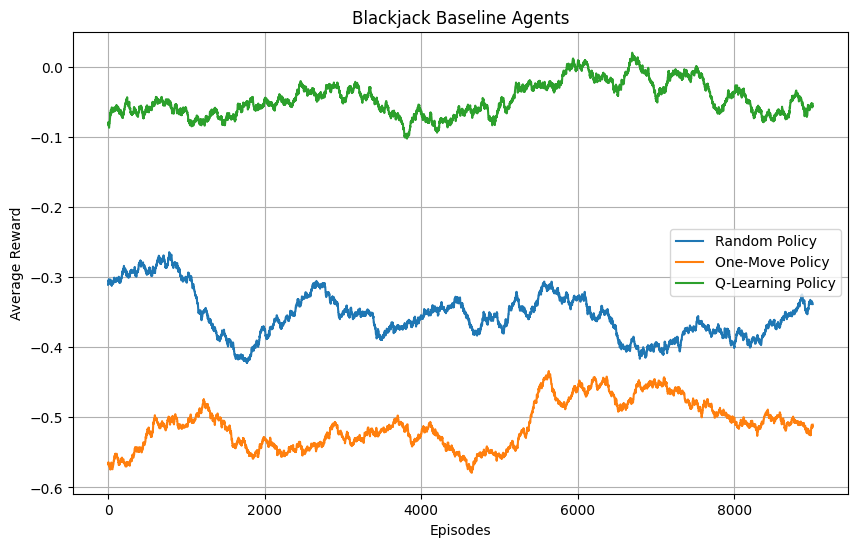

In [10]:
# Set the size of the figure for better visibility
plt.figure(figsize=(10, 6))

# Plot the performance of all agents using their respective reward histories
plot_results({
    "Random Policy": random_rewards,         # Rewards from the random agent
    "One-Move Policy": one_move_rewards,     # Rewards from the fixed-rule agent
    "Q-Learning Policy": q_learning_rewards      # Rewards from the hypertuned Q-learning agent
})

In [13]:
from IPython.display import Markdown as md

md(f"The evaluation results reveal notable differences in performance among the baseline agents. The random policy, with an average score of {np.mean(random_rewards)}, performs better than the one-move policy, which scores {np.mean(one_move_rewards)}, indicating that the simple heuristic did not improve outcomes over random actions. In contrast, the Q-learning agent significantly outperforms both, achieving an average score of {np.mean(q_learning_rewards) }. <br> These results highlight the clear advantage of adaptive learning methods over fixed or random strategies in the Blackjack environment and serve as solid performance baselines for the more sophisticated deep learnig models we aim to develop.")

The evaluation results reveal notable differences in performance among the baseline agents. The random policy, with an average score of -0.3529, performs better than the one-move policy, which scores -0.5139, indicating that the simple heuristic did not improve outcomes over random actions. In contrast, the Q-learning agent significantly outperforms both, achieving an average score of -0.0494. <br> These results highlight the clear advantage of adaptive learning methods over fixed or random strategies in the Blackjack environment and serve as solid performance baselines for the more sophisticated deep learnig models we aim to develop.